# plot

## Cluster Setting
Dask is a flexible library for parallel computing in Python. 

Dask.distributed is a lightweight library for distributed computing in Python.

The Client is the primary entry point for users of dask.distributed.

In [1]:
## Distributed computing
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster

cluster = KubeCluster() # reads provided yaml file
# cluster.scale_up(10)  # specify number of nodes explicitly
# cluster.adapt(minimum=1, maximum=100)  # or dynamically scale based on current workload
cluster.adapt(maximum=30)
cluster

In [2]:
# Connect to distributed cluster and override default
client = Client(cluster) 
client

Client Scheduler: tcp://10.32.5.193:38499 Dashboard: /user/0000-0001-5234-177x/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Environment Setting

In [3]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0' # disabled the __array_function__ protocol
# Some info bout the above protocol can be found on :
# http://blog.christianperone.com/2019/07/numpy-dispatcher-when-numpy-becomes-a-protocol-for-an-ecosystem/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import gsw # Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
from tqdm import tqdm # show progress meter
import cartopy.crs as ccrs 
import cartopy
import xesmf as xe

from xhistogram.xarray import histogram

%matplotlib inline
# plt.rcParams['figure.figsize'] = 12, 6
# %config InlineBackend.figure_format = 'retina'  #enabling 2x PNG matplotlib plots in the IPython notebook

In [4]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds        

Fetch the data from 15 models that have biogeochem output.



In [5]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
models = ['CanESM5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GFDL-CM4',
          'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'IPSL-CM6A-LR', 'MIROC-ES2l',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'UKESM1-0-LL']
var = 'tos'
expe = 'historical'
freq = 'Omon'

xrays = []
for model in tqdm(models):
    xray = get_data(df, var, model, expe, freq)
    xrays.append(xray)
xray_dic = {key:value for key, value in zip(models, xrays)}

 27%|██▋       | 4/15 [00:03<00:09,  1.11it/s]

GFDL-CM4 : no data


 73%|███████▎  | 11/15 [00:06<00:02,  1.97it/s]

MIROC-ES2l : no data
MPI-ESM1-2-HR : no data


 93%|█████████▎| 14/15 [00:07<00:00,  2.28it/s]

NorCPM1 : no data
NorESM2-LM : no data


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


## regridding

Behzad's code for regriding:

nearest from scipy.interpolate.datagrid
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


In [6]:
def Regridding(data, grid_out):
    grid_11 = xr.Dataset({'lat': (grid_out.lat), 'lon': (grid_out.lon)})
    regrid = xe.Regridder(data, grid_11, 
                      'bilinear', periodic=True, reuse_weights=True)
    return regrid(data)

from Behzadlib import func_regrid

In [7]:
# Create a Global 2D rectilinear grid 
ds_out = xe.util.grid_global(1, 1)



AttributeError: 'AxesSubplot' object has no attribute 'coastlines'

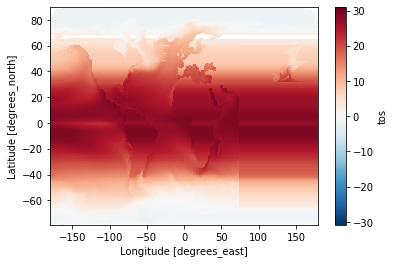

In [25]:
s = xray_dic['CNRM-ESM2-1'].sel(time=slice('1990','2009')).mean(dim='time').tos
ax = plt.axes();
s.plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();
# s.lon[0].values
#print(s.lon-180)
#s.assign_coords(lon=(((s.lon + 180) % 360) - 180))
# s.plot()

Text(0, 0.5, 'lat')

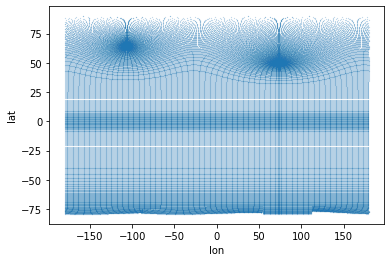

In [26]:
plt.scatter(s['lon'], s['lat'], s=0.01)  # plot grid locations
#plt.ylim([-90, 90])
plt.xlabel('lon')
plt.ylabel('lat')

In [27]:
s = xray_dic['CNRM-ESM2-1'].sel(time=slice('1990','2009')).mean(dim='time').tos
s_out1 = Regridding(s, ds_out)
# s_out2 = func_regrid(s, s.lat, s.lon, ds_out.lat, ds_out.lon)

Create weight file: bilinear_294x362_180x360_peri.nc


ValueError: ESMC_FieldRegridStoreFile() failed with rc = 506.    Please check the log files (named "*ESMF_LogFile").

Text(0, 0.5, 'lat')

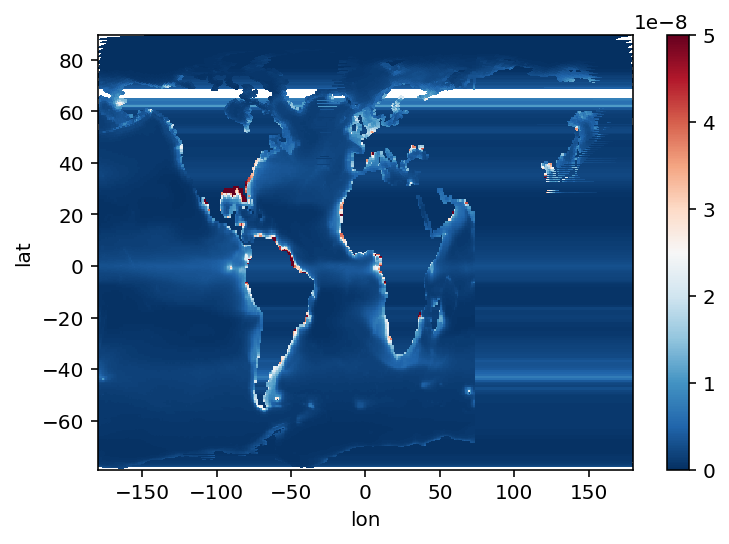

In [30]:
S = xray_dic['CNRM-ESM2-1'].sel(time=slice('1990','2009')).mean(dim='time').mean(dim='lev').pp
plt.pcolormesh(S.lon, S.lat, S, cmap=plt.cm.RdBu_r, vmin=0.,vmax=10**-6)
plt.colorbar()
plt.xlabel('lon')
plt.ylabel('lat')

    

  0%|          | 0/15 [00:00<?, ?it/s]distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
 27%|██▋       | 4/15 [00:10<00:34,  3.13s/it]

GFDL-CM4  Error:  'list' object has no attribute 'sel'


 60%|██████    | 9/15 [00:19<00:11,  1.87s/it]

MIROC-ES2l  Error:  'list' object has no attribute 'sel'
MPI-ESM1-2-HR  Error:  'list' object has no attribute 'sel'


 80%|████████  | 12/15 [00:21<00:04,  1.48s/it]

NorCPM1  Error:  'list' object has no attribute 'sel'
NorESM2-LM  Error:  'list' object has no attribute 'sel'


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


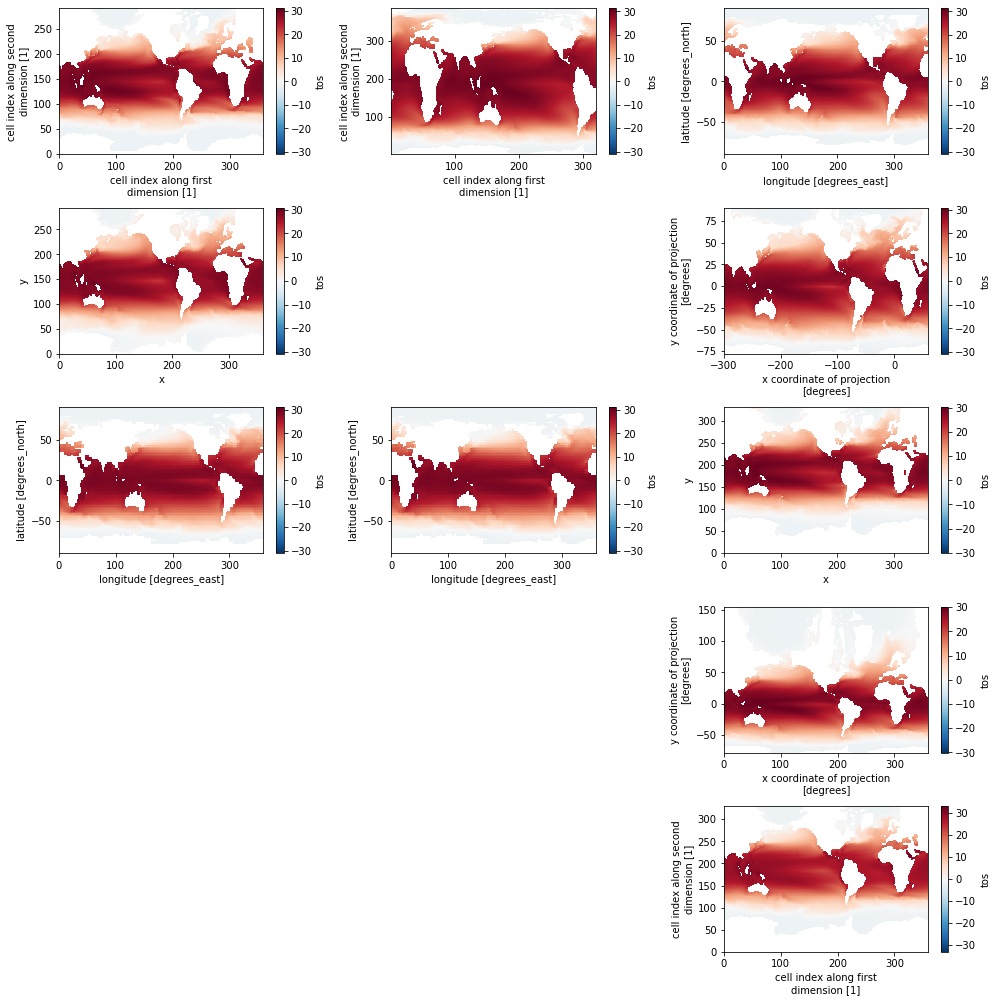

distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [8]:
plt.figure(figsize=(14,14))
i = 0
for model in tqdm(models):  
    i = i + 1
    try:
        data = xray_dic[model].sel(time=slice('1986','2005')).mean(dim='time').tos        
    except Exception as e:
        print(model,' Error: ',e)
        continue
    ax = plt.subplot(5,3,i)
    data.plot()
    

plt.tight_layout()